In [ ]:
# ----------------------------------------------------------------------------
# --- LOADING TOOLS AND DATA
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc, 
                             roc_auc_score)
from scipy import stats
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("LOADING DATASET: COLON CANCER")
print("="*60)

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"

X = pd.read_csv(DATA_DIR / "high_dimension/colon_genes.csv", sep=",", index_col=0)
y = pd.read_csv(DATA_DIR / "high_dimension/colon_classes.csv", sep=",", index_col=0)
n, p = X.shape

print(f"Observations: {n}")
print(f"Genes (p): {p}")
print(f"Ratio p/n: {p/n:.2f}")
print(f"Classes: {y.value_counts().to_dict()}")

# Check NA
na_count = X.isnull().sum().sum()
print(f"\nMissing values: {na_count}")

if na_count > 0:
    X = X.fillna(X.mean())

# Check constant values
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"Constant columns: {len(constant_cols)}")
    X = X.drop(columns=constant_cols)

LOADING DATASET: COLON CANCER
Observations: 62
Genes (p): 2000
Ratio p/n: 32.26
Classes: {('t',): 40, ('n',): 22}

Missing values: 0


In [ ]:
# ----------------------------------------------------------------------------
# --- K-FOLD CROSS-VALIDATION REGRESSION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION")
print("="*60)

# utility for XGBoost
y = y['class'].map({'n': 0, 't': 1})
assert set(y.unique()) == {0, 1}

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)

y_vec = y
class_labels = sorted(y_vec.unique().tolist())
n_classes = len(class_labels)
# Feature selection inside each fold

# --- SUPPORT FUNCTIONS

def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=class_labels[1], zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=class_labels[1], zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=class_labels[1], zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    # Specificity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'confusion_matrix': cm
    }

def feature_selection_ttest(X_train, y_train, top_n=100):
    """Feature selection using t-test"""
    p_values = []
    
    for col in X_train.columns:
        group1 = X_train.loc[y_train == class_labels[0], col]
        group2 = X_train.loc[y_train == class_labels[1], col]
        
        _, p_val = stats.ttest_ind(group1, group2)
        p_values.append(p_val)
    
    # order by p_value and keep top N
    p_val_df = pd.DataFrame({'gene': X_train.columns, 'p_value': p_values})
    top_features = p_val_df.nsmallest(top_n, 'p_value')['gene'].tolist()
    
    return top_features

def feature_selection_variance(X_train, top_n=100):
    """Feature selection using variance"""
    variances = X_train.var()
    top_features = variances.nlargest(top_n).index.tolist()
    return top_features

# --- DEFINE MODELS

models = {
    'ridge': LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', 
                                max_iter=1000, random_state=42),
    'lasso': LogisticRegression(penalty='l1', C=1.0, solver='liblinear', 
                                max_iter=1000, random_state=42),
    'enet': LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5,
                               solver='saga', max_iter=1000, random_state=42),
    'rf': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    'svm': SVC(kernel='linear', probability=True, random_state=42),
    'xgb': xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3,
                             subsample=0.8, colsample_bytree=0.8,
                             random_state=42, n_jobs=-1, eval_metric='logloss'),
    'nb': GaussianNB()
}

model_labels = {
    'ridge': 'Ridge Logistic',
    'lasso': 'Lasso Logistic',
    'enet': 'Elastic Net',
    'rf': 'Random Forest',
    'svm': 'SVM Linear',
    'xgb': 'XGBoost',
    'nb': 'Naive Bayes'
}

# --- START LOOP FOR CV

predictions_all = {model_name: {'y_true': [], 'y_pred': [], 'y_prob': []} 
                   for model_name in models.keys()}

fold_metrics = {model_name: [] for model_name in models.keys()}
selected_features_all = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- FOLD {fold}/{K} ---")
    
    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    
    # FEATURE SELECTION (p > n)

    print(f"Feature selection: top 100 genes using t-test")
    selected_features = feature_selection_ttest(X_train, y_train, top_n=100)
    selected_features_all.append(selected_features)
    
    # Selecting...
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    print(f"Selected features: {p} → {len(selected_features)}")
    
    # Train and predict for each model
    for model_name, model in models.items():
        from sklearn.base import clone
        model_fold = clone(model)
        
        # Train
        model_fold.fit(X_train_selected, y_train)
        
        # Predict
        y_pred = model_fold.predict(X_test_selected)

        # Probability: positive class
        pos_idx = list(model_fold.classes_).index(1)
        y_prob = model_fold.predict_proba(X_test_selected)[:, pos_idx]

        # Save
        predictions_all[model_name]['y_true'].extend(y_test.values)
        predictions_all[model_name]['y_pred'].extend(y_pred)
        predictions_all[model_name]['y_prob'].extend(y_prob)
        
        # Fold metrics
        metrics = compute_metrics(y_test, y_pred, y_prob)
        fold_metrics[model_name].append(metrics)

print("\n K-Fold CV completed!")


K-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---
Feature selection: top 100 genes using t-test
Selected features: 2000 → 100

--- FOLD 2/5 ---
Feature selection: top 100 genes using t-test
Selected features: 2000 → 100

--- FOLD 3/5 ---
Feature selection: top 100 genes using t-test
Selected features: 2000 → 100

--- FOLD 4/5 ---
Feature selection: top 100 genes using t-test
Selected features: 2000 → 100

--- FOLD 5/5 ---
Feature selection: top 100 genes using t-test
Selected features: 2000 → 100

 K-Fold CV completed!



PRESENTING THE RESULTS: MODELS COMPARISON

         Model  Accuracy_mean  Accuracy_sd  F1_mean  Precision_mean
    SVM Linear       0.873077     0.065592 0.900915        0.886984
   Elastic Net       0.856410     0.062249 0.885677        0.886984
Ridge Logistic       0.856410     0.062249 0.885677        0.886984
 Random Forest       0.841026     0.073843 0.874752        0.894661
Lasso Logistic       0.839744     0.078901 0.872680        0.880635
       XGBoost       0.823077     0.030609 0.866690        0.850556
   Naive Bayes       0.760256     0.160743 0.776948        0.891667

Selection of Elastic Net as best model because:
similar performance with SVM Linear
better interpretability

Best model: Elastic Net
Mean Accuracy: 0.8564 ± 0.0622
Mean F1-Score: 0.8857

FEATURE STABILITY ANALYSIS

20 most stable genes:
   1. Hsa.8147: 1.00
   2. Hsa.692.2: 1.00
   3. Hsa.37937: 1.00
   4. Hsa.692: 1.00
   5. Hsa.1832: 1.00
   6. Hsa.692.1: 1.00
   7. Hsa.36689: 1.00
   8. Hsa.1131: 1.00
   

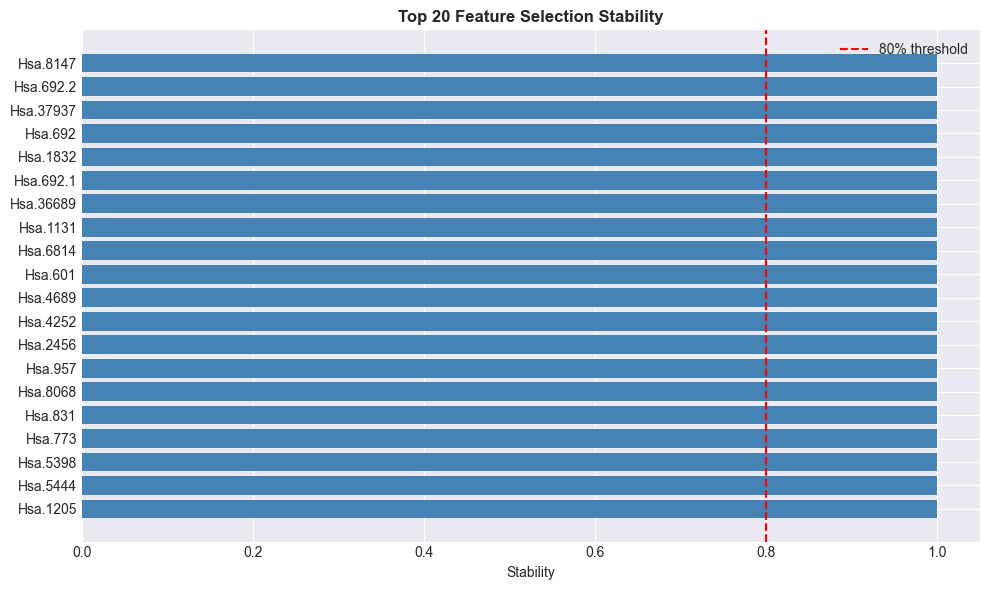

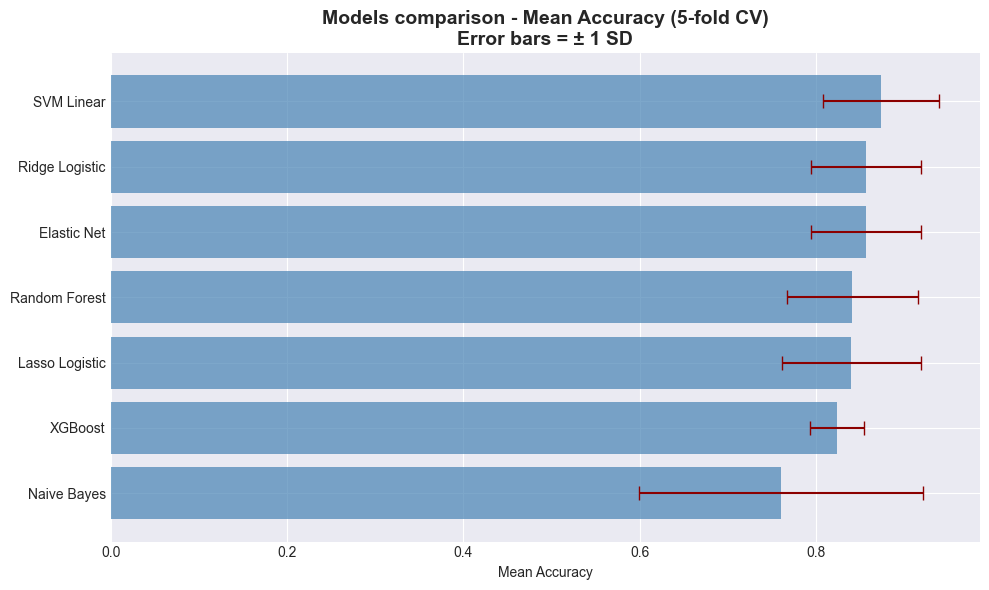

In [ ]:
# ----------------------------------------------------------------------------
# --- RESULTS AGGREGATION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("PRESENTING THE RESULTS: MODELS COMPARISON")
print("="*60)

cv_results = []

for model_name in models.keys():
    # Metrics per fold
    acc_folds = [m['accuracy'] for m in fold_metrics[model_name]]
    f1_folds = [m['f1'] for m in fold_metrics[model_name]]
    prec_folds = [m['precision'] for m in fold_metrics[model_name]]
    rec_folds = [m['recall'] for m in fold_metrics[model_name]]
    spec_folds = [m['specificity'] for m in fold_metrics[model_name]]
    
    # Global metrics
    y_true_all = np.array(predictions_all[model_name]['y_true'])
    y_pred_all = np.array(predictions_all[model_name]['y_pred'])
    global_metrics = compute_metrics(y_true_all, y_pred_all)
    
    cv_results.append({
        'Model': model_labels[model_name],
        'Model_Code': model_name,
        'Accuracy_mean': np.mean(acc_folds),
        'Accuracy_sd': np.std(acc_folds, ddof=1),
        'F1_mean': np.mean(f1_folds),
        'Precision_mean': np.mean(prec_folds),
        'Recall_mean': np.mean(rec_folds),
        'Specificity_mean': np.mean(spec_folds)
    })

cv_summary = pd.DataFrame(cv_results).sort_values('Accuracy_mean', ascending=False)

print("\n" + cv_summary[['Model', 'Accuracy_mean', 'Accuracy_sd', 'F1_mean', 'Precision_mean']].to_string(index=False))

# Best model
best_model_row = cv_summary.iloc[1]
best_model_name = best_model_row['Model']
best_model_code = best_model_row['Model_Code']

print(f"\nSelection of Elastic Net as best model because:\nsimilar performance with SVM Linear\nbetter interpretability") 

print(f"\nBest model: {best_model_name}")
print(f"Mean Accuracy: {best_model_row['Accuracy_mean']:.4f} ± {best_model_row['Accuracy_sd']:.4f}")
print(f"Mean F1-Score: {best_model_row['F1_mean']:.4f}")

# FEATURE STABILITY ANALYSIS

print("\n" + "="*60)
print("FEATURE STABILITY ANALYSIS")
print("="*60)

from collections import Counter
all_features = [f for fold_features in selected_features_all for f in fold_features]
feature_counts = Counter(all_features)
feature_stability = {gene: count/K for gene, count in feature_counts.items()}
feature_stability_sorted = sorted(feature_stability.items(), key=lambda x: x[1], reverse=True)

print(f"\n20 most stable genes:")
for i, (gene, freq) in enumerate(feature_stability_sorted[:20], 1):
    print(f"  {i:2d}. {gene}: {freq:.2f}")

stable_genes = [gene for gene, freq in feature_stability.items() if freq >= 0.8]
print(f"\nStable genes (≥80% folds): {len(stable_genes)}")

# Plot stability
stability_df = pd.DataFrame(feature_stability_sorted[:20], 
                           columns=['Gene', 'Stability'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(stability_df)), stability_df['Stability'], color='steelblue')
ax.set_yticks(range(len(stability_df)))
ax.set_yticklabels(stability_df['Gene'])
ax.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
ax.set_xlabel('Stability')
ax.set_title('Top 20 Feature Selection Stability', fontweight='bold')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# --- VISUALS

# Plot: Accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))
cv_sorted = cv_summary.sort_values('Accuracy_mean', ascending=True)
y_pos = np.arange(len(cv_sorted))

ax.barh(y_pos, cv_sorted['Accuracy_mean'], alpha=0.7, color='steelblue')
ax.errorbar(cv_sorted['Accuracy_mean'], y_pos, 
            xerr=cv_sorted['Accuracy_sd'], 
            fmt='none', ecolor='darkred', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(cv_sorted['Model'])
ax.set_xlabel('Mean Accuracy')
ax.set_title('Models comparison - Mean Accuracy (5-fold CV)\nError bars = ± 1 SD', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


RE-RUNNING THE BEST MODEL ON THE DATA

Used features: 100
Accuracy: 0.9839
Precision: 1.0000
Recall: 0.9750
F1-Score: 0.9873
Specificity: 1.0000

Confusion Matrix:
    0   1
0  22   0
1   1  39

Intercept: -0.0000
Selected genes: 100 su 100
Sparsity: 0.00%

20 most important genes:
     Gene  Coefficient Direction
Hsa.692.2    -0.002037    Normal
Hsa.37937    -0.001840    Normal
 Hsa.5398     0.001677     Tumor
 Hsa.4689    -0.001514    Normal
 Hsa.3016     0.001353     Tumor
 Hsa.8068     0.001335     Tumor
 Hsa.1832    -0.001281    Normal
Hsa.36689    -0.001254    Normal
 Hsa.9972     0.001242     Tumor
Hsa.43279    -0.001224    Normal
 Hsa.2553     0.001218     Tumor
 Hsa.5444    -0.001066    Normal
Hsa.692.1     0.001032     Tumor
Hsa.36952    -0.001015    Normal
 Hsa.8125    -0.001011    Normal
Hsa.33965     0.000953     Tumor
 Hsa.7395     0.000924     Tumor
 Hsa.1130     0.000910     Tumor
 Hsa.1902     0.000890     Tumor
 Hsa.1131    -0.000858    Normal


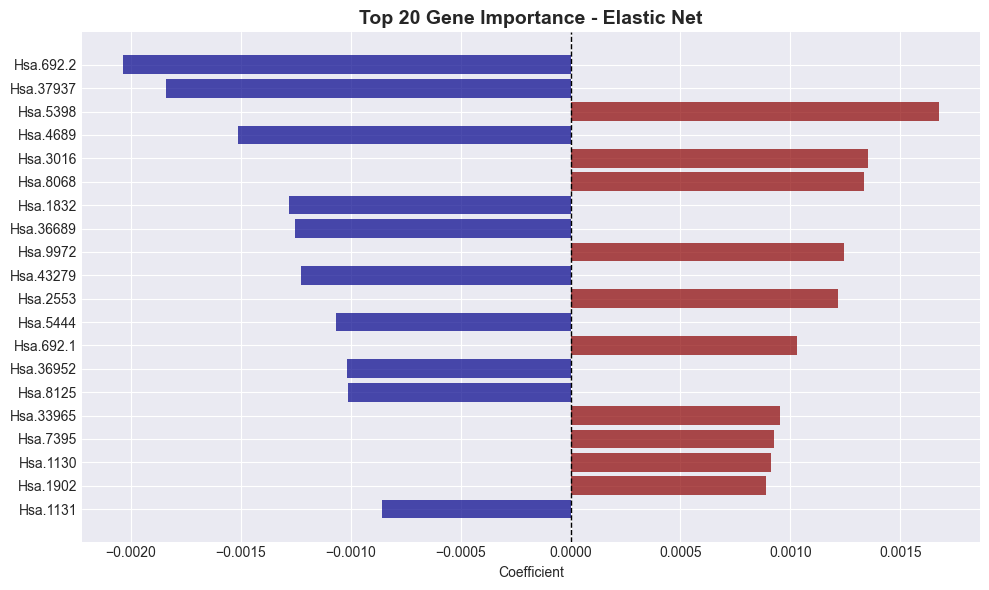


AUC: 1.0000


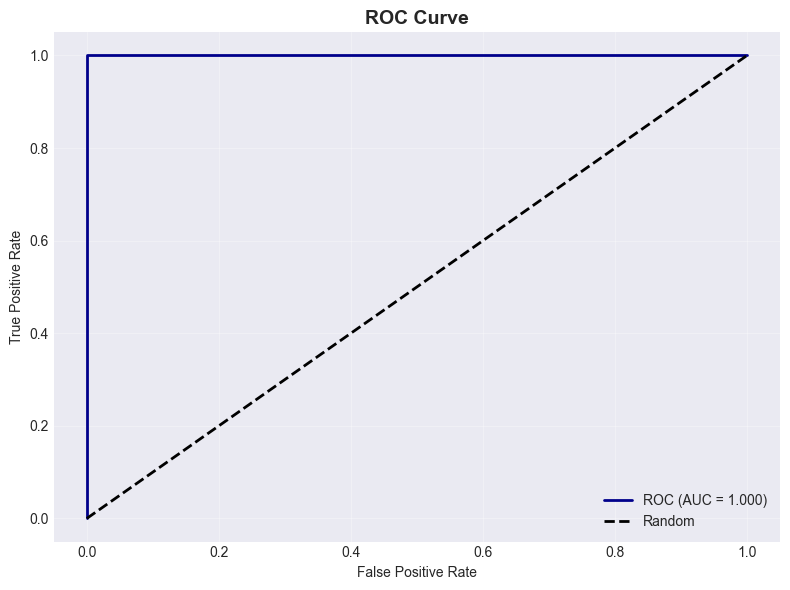

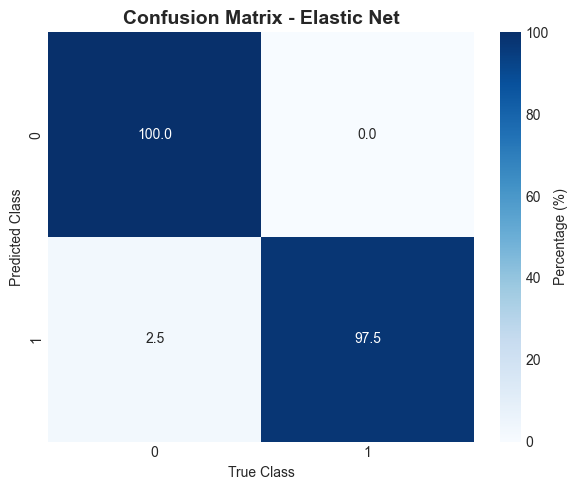

Mean: 0.6473
Median: 0.9717

Correctly predicted: 61/62 (98.39%)
Mean Confidence (correctly classified): 0.6507
Mean Confidence (misclassified): 0.4426

SUMMARY TABLE OF RESULTS

             Metric       Value
              Model Elastic Net
     n observations          62
 p genes (original)        2000
 p genes (selected)         100
          Ratio p/n        32.3
 CV Accuracy (mean)      0.8564
   CV Accuracy (sd)      0.0622
 CV F1-Score (mean)      0.8857
  Training Accuracy      0.9839
                AUC      1.0000
Stable genes (≥80%)          71
   Top gene (Tumor)    Hsa.5398
  Top gene (Normal)   Hsa.692.2

COMPLETED

Saved files:
- final_highdim_classification_enet.pkl
- selected_features_classification.pkl
- cv_highdim_classification_results.csv
- summary_highdim_classification.csv
- gene_coefficients_classification.csv


In [ ]:
# ----------------------------------------------------------------------------
# --- RE-RUNNING OF BEST MODEL ON ENTIRE DATASET
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("RE-RUNNING THE BEST MODEL ON THE DATA")
print("="*60)

# Feature selection on the entire dataset
best_features = feature_selection_ttest(X, y, top_n=100)
X_final = X[best_features]

print(f"\nUsed features: {len(best_features)}")

# Re-run
from sklearn.base import clone
final_model = clone(models[best_model_code])
final_model.fit(X_final, y)

# save
import pickle
with open(f'final_highdim_classification_{best_model_code}.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('selected_features_classification.pkl', 'wb') as f:
    pickle.dump(best_features, f)

# --- BEST MODEL ANALYSIS: LOGISTIC REGRESSION

if best_model_code in ['ridge', 'lasso', 'enet']:
    
    # Predictions
    y_pred_train = final_model.predict(X_final)
    y_prob_train = final_model.predict_proba(X_final)[:, 1]
    train_metrics = compute_metrics(y, y_pred_train, y_prob_train)
    cm_train = train_metrics['confusion_matrix']
    
    print(f"Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Precision: {train_metrics['precision']:.4f}")
    print(f"Recall: {train_metrics['recall']:.4f}")
    print(f"F1-Score: {train_metrics['f1']:.4f}")
    print(f"Specificity: {train_metrics['specificity']:.4f}")    
    print(f"\nConfusion Matrix:")
    print(pd.DataFrame(cm_train, index=class_labels, columns=class_labels))
    
    # Coefficients
    intercept = final_model.intercept_[0]
    coefs = final_model.coef_[0]
    
    # Selected genes (non-zero using Lasso/ElasticNet)
    if best_model_code in ['lasso', 'enet']:
        nonzero_idx = np.where(coefs != 0)[0]
        selected_genes = [best_features[i] for i in nonzero_idx]
        selected_coefs = coefs[nonzero_idx]
        
        print(f"\nIntercept: {intercept:.4f}")
        print(f"Selected genes: {len(selected_genes)} su {len(coefs)}")
        print(f"Sparsity: {100 * (1 - len(selected_genes)/len(coefs)):.2f}%")
    else:  # Ridge
        selected_genes = best_features
        selected_coefs = coefs
        print(f"\nIntercept: {intercept:.4f}")
        print(f"! Ridge uses all {len(coefs)} genes (no sparsity)")
    
    coef_df = pd.DataFrame({
        'Gene': selected_genes,
        'Coefficient': selected_coefs
    })
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    coef_df['Direction'] = coef_df['Coefficient'].apply(
        lambda x: 'Tumor' if x > 0 else 'Normal'
    )
    
    print(f"\n20 most important genes:")
    print(coef_df[['Gene', 'Coefficient', 'Direction']].head(20).to_string(index=False))
    
    # Plot coefficients
    fig, ax = plt.subplots(figsize=(10, 6))
    top20 = coef_df.head(20).sort_values('Abs_Coefficient', ascending=True)
    colors = ['darkred' if c > 0 else 'darkblue' for c in top20['Coefficient']]
    
    ax.barh(range(len(top20)), top20['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['Gene'])
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Coefficient')
    ax.set_title(f'Top 20 Gene Importance - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve
    from sklearn.metrics import roc_auc_score
    
    fpr, tpr, thresholds = roc_curve(y, y_prob_train, pos_label=class_labels[1])
    roc_auc = auc(fpr, tpr)
    
    print(f"\nAUC: {roc_auc:.4f}")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    cm_pct = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Percentage (%)'})
    ax.set_xlabel('True Class')
    ax.set_ylabel('Predicted Class')
    ax.set_title(f'Confusion Matrix - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Confidence analysis - Probability
    print(f"Mean: {y_prob_train.mean():.4f}")
    print(f"Median: {np.median(y_prob_train):.4f}")
    
    correct = (y_pred_train == y.values)
    print(f"\nCorrectly predicted: {correct.sum()}/{len(y)} ({100*correct.sum()/len(y):.2f}%)")
    print(f"Mean Confidence (correctly classified): {y_prob_train[correct].mean():.4f}")
    print(f"Mean Confidence (misclassified): {y_prob_train[~correct].mean():.4f}")

# --- SUMMARY

print("\n" + "="*60)
print("SUMMARY TABLE OF RESULTS")
print("="*60)

if 'coef_df' in locals():
    top_tumor_gene = coef_df[coef_df['Direction'] == 'Tumor'].iloc[0]['Gene'] if len(coef_df[coef_df['Direction'] == 'Tumor']) > 0 else 'N/A'
    top_normal_gene = coef_df[coef_df['Direction'] == 'Normal'].iloc[0]['Gene'] if len(coef_df[coef_df['Direction'] == 'Normal']) > 0 else 'N/A'
    n_selected = len(selected_genes) if best_model_code in ['lasso', 'enet'] else len(best_features)
else:
    top_tumor_gene = 'N/A'
    top_normal_gene = 'N/A'
    n_selected = len(best_features)

summary_data = {
    'Metric': [
        'Model',
        'n observations',
        'p genes (original)',
        'p genes (selected)',
        'Ratio p/n',
        'CV Accuracy (mean)',
        'CV Accuracy (sd)',
        'CV F1-Score (mean)',
        'Training Accuracy',
        'AUC',
        'Stable genes (≥80%)',
        'Top gene (Tumor)',
        'Top gene (Normal)'
    ],
    'Value': [
        best_model_name,
        str(n),
        str(p),
        str(n_selected),
        f"{p/n:.1f}",
        f"{best_model_row['Accuracy_mean']:.4f}",
        f"{best_model_row['Accuracy_sd']:.4f}",
        f"{best_model_row['F1_mean']:.4f}",
        f"{train_metrics['accuracy']:.4f}" if 'train_metrics' in locals() else 'N/A',
        f"{roc_auc:.4f}" if 'roc_auc' in locals() else 'N/A',
        str(len(stable_genes)),
        top_tumor_gene,
        top_normal_gene
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n" + summary_table.to_string(index=False))

# save results

cv_summary.to_csv('cv_highdim_classification_results.csv', index=False)
summary_table.to_csv('summary_highdim_classification.csv', index=False)

if 'coef_df' in locals():
    coef_df.to_csv('gene_coefficients_classification.csv', index=False)

print("\n" + "="*60)
print("COMPLETED")
print("="*60)
print("\nSaved files:")
print(f"- final_highdim_classification_{best_model_code}.pkl")
print("- selected_features_classification.pkl")
print("- cv_highdim_classification_results.csv")
print("- summary_highdim_classification.csv")
if 'coef_df' in locals():
    print("- gene_coefficients_classification.csv")